In [1]:
import os
imdb_dir = '/Users/halahalsaadi/Downloads/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [54]:
maxlen = 100 
training_samples = 500 
validation_samples = 10000 
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)


Found 87393 unique tokens.


In [55]:
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [56]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]


In [57]:
glove_dir = '/Users/halahalsaadi/Downloads/glove'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [58]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [59]:
epochs = 15
batch_size = 128

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.layers import LSTM
model = Sequential()
model.add(Embedding(max_words, 100))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 1,017,057
Trainable params: 1,017,057
Non-trainable params: 0
_________________________________________________________________


In [60]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [61]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=15,
                    batch_size=128,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 500 samples, validate on 10000 samples
Epoch 1/15
500/500 [==============================] - 5s 9ms/step - loss: 0.6872 - acc: 0.5680 - val_loss: 0.6922 - val_acc: 0.5343
Epoch 2/15
500/500 [==============================] - 3s 6ms/step - loss: 0.6760 - acc: 0.5900 - val_loss: 0.6875 - val_acc: 0.5307
Epoch 3/15
500/500 [==============================] - 3s 6ms/step - loss: 0.6624 - acc: 0.6060 - val_loss: 0.6803 - val_acc: 0.5768
Epoch 4/15
500/500 [==============================] - 3s 6ms/step - loss: 0.6567 - acc: 0.6160 - val_loss: 0.6748 - val_acc: 0.5861
Epoch 5/15
500/500 [==============================] - 3s 6ms/step - loss: 0.6444 - acc: 0.6500 - val_loss: 0.6704 - val_acc: 0.5974
Epoch 6/15
500/500 [==============================] - 3s 6ms/step - loss: 0.6251 - acc: 0.6940 - val_loss: 0.6579 - val_acc: 0.6211
Epoch 7/15
500/500 [==============================] - 3s 7ms/step - loss: 0.6155 - acc: 0.6740 - val_loss: 0.6679 - val_acc: 0.5821
Epoch 8/15
500/500 [========

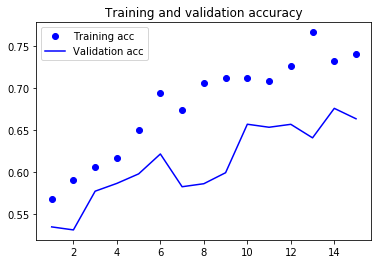

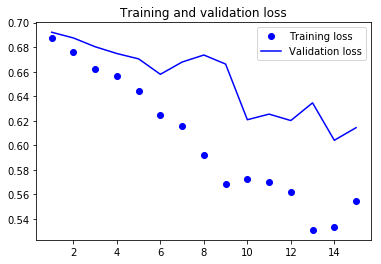

In [62]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [63]:
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)


In [64]:
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [65]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 13s 529us/step


[0.6160867576980591, 0.65904]

In [66]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.7533562291145325
Test accuracy: 0.5288
